In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Importando os arquivos

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(1460, 81)

In [4]:
test.shape

(1459, 80)

In [5]:
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
MSSubClass       2919 non-null int64
MSZoning         2915 non-null object
LotFrontage      2433 non-null float64
LotArea          2919 non-null int64
Street           2919 non-null object
Alley            198 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2917 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null int64
OverallCond      2919 non-null int64
YearBuilt        2919 non-null int64
YearRemodAdd     2919 non-null int64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2918 non-null object
Exterior2nd      2918 non

# Treating the dataset

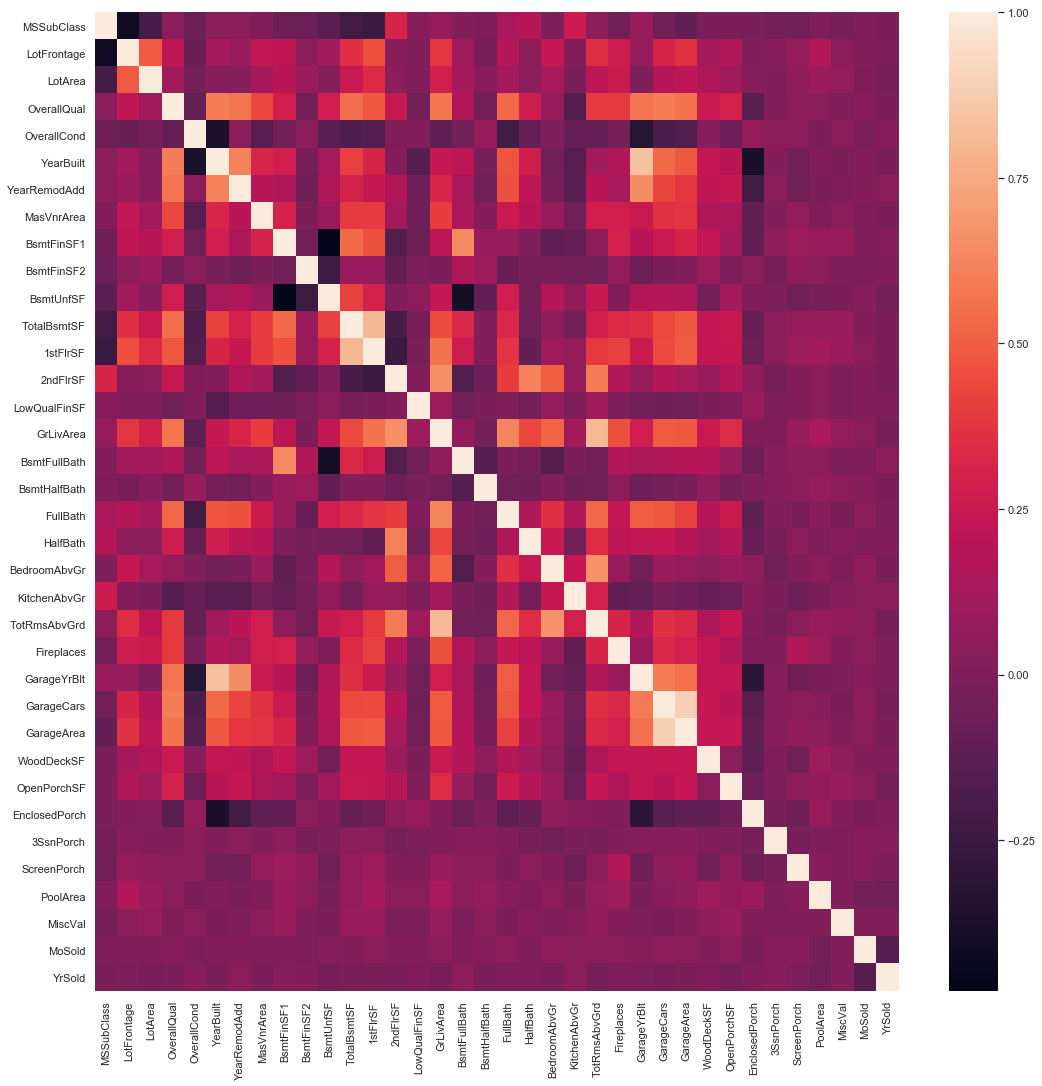

In [14]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.set()
sns.heatmap(data.corr())

In [11]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']

In [12]:
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']

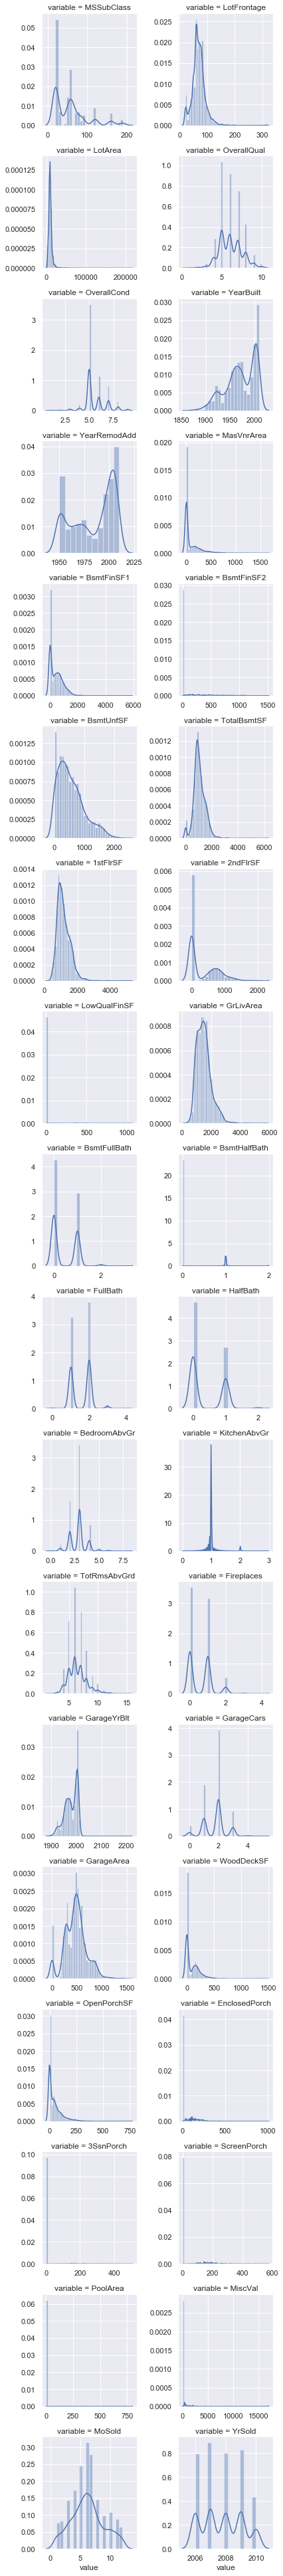

In [13]:
f = pd.melt(data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

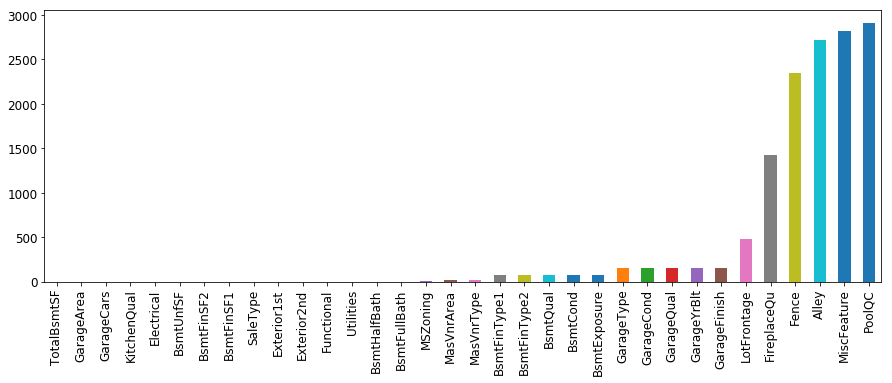

In [9]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(fontsize=12,figsize=(15,5))

In [10]:
for c in qualitative:
    data[c] = data[c].astype('category')
    if data[c].isnull().any():
        data[c] = data[c].cat.add_categories(['MISSING'])
        data[c] = data[c].fillna('MISSING')

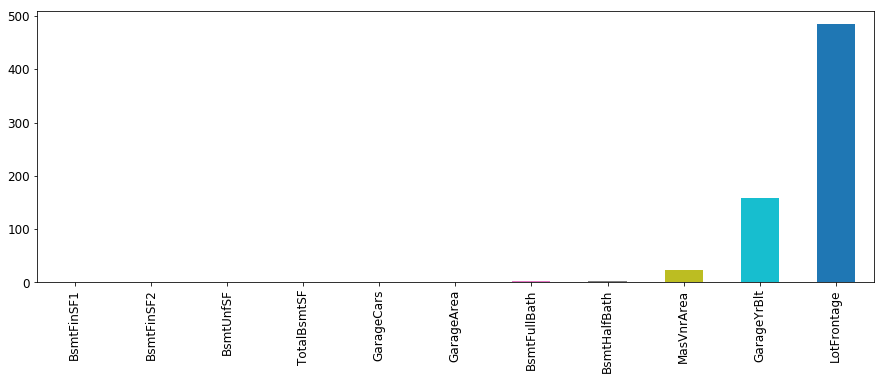

In [11]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(fontsize=12,figsize=(15,5))

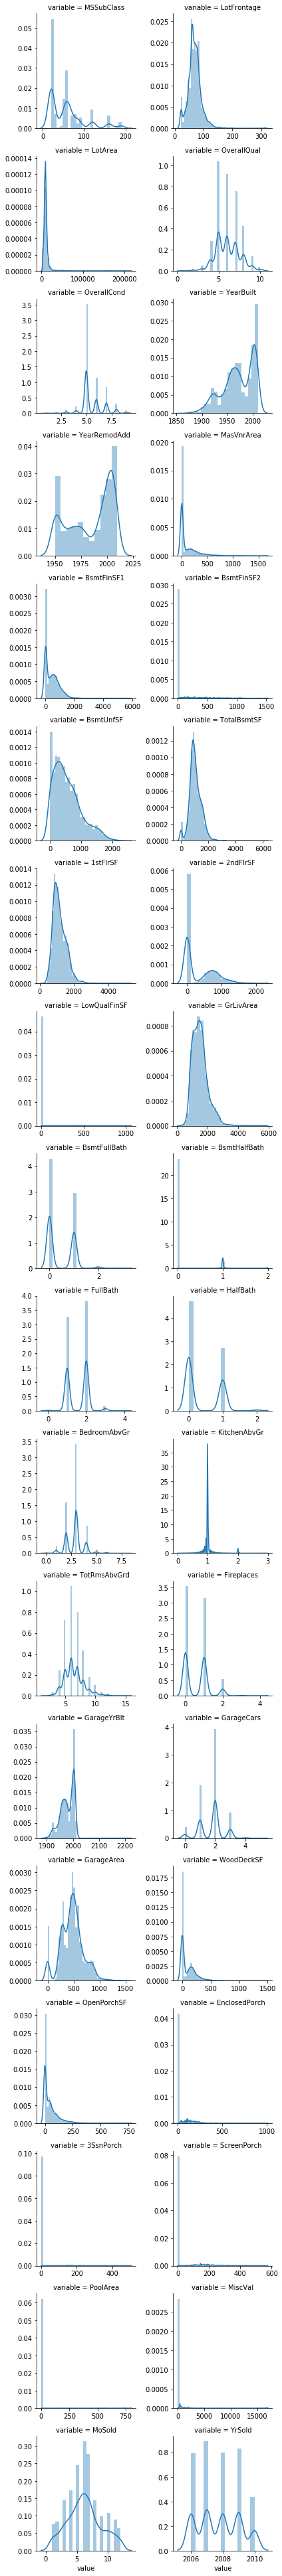

In [12]:
f = pd.melt(data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [185]:
from scipy.stats import skew

skewed_feats = data[quantitative].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

data[skewed_feats] = np.log1p(data[skewed_feats])

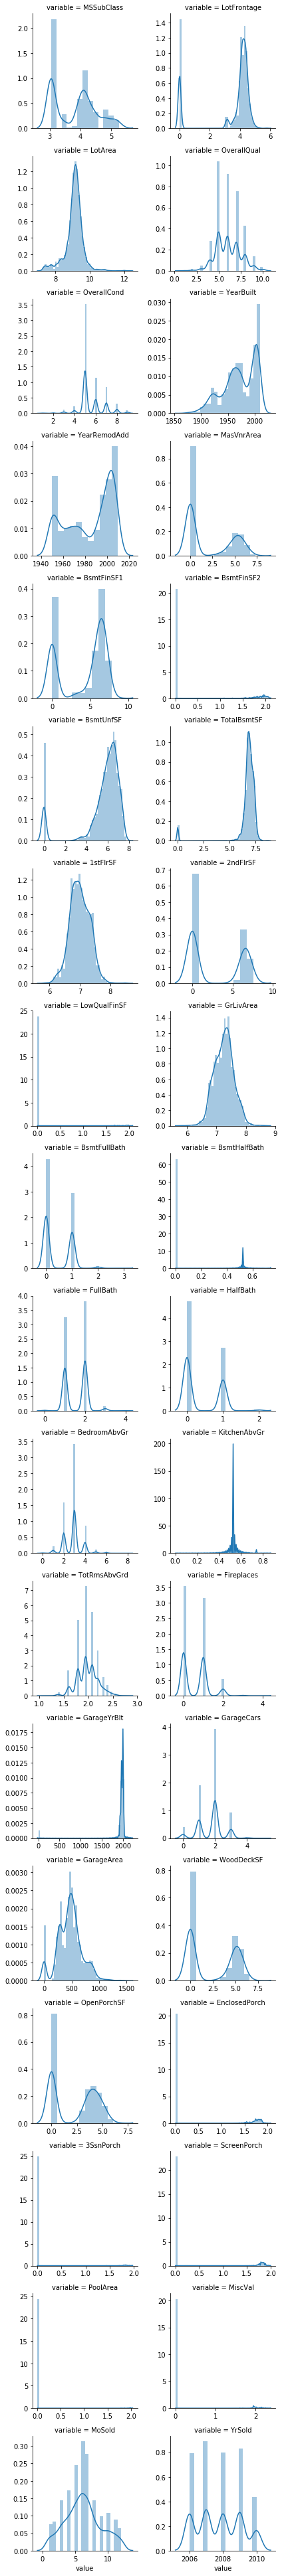

In [186]:
f = pd.melt(data, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [187]:
for cols in quantitative:
    data[cols +'2'] = data[cols] ** 2

In [188]:
for cols in quantitative:
    data[cols +'3'] = data[cols] ** 3

In [189]:
data = pd.get_dummies(data)

In [190]:
data = data.fillna(0)

# Defining train and test datasets

In [228]:
X_train = data[:train.shape[0]]
y_train = train.SalePrice
X_test = data[train.shape[0]:]

# _____ _____ _____

# Running models

In [318]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV, ElasticNetCV

import xgboost as xgb
from xgboost import XGBClassifier,XGBRegressor

def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

# _____ _____ _____

# Testing Lasso

In [261]:
from sklearn import linear_model

In [262]:
# Treino do modelo diretamente no set de treino 

lasso = Lasso()
lasso.fit(X_train, np.log(y_train))

y_pred_train = np.exp(lasso.predict(X_train))
error(y_train, y_pred_train)

0.1451899544818959

# Lasso train_test_split

In [401]:
# Cross-Validation with train_test_split

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [402]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.2)
print (XX_train.shape, yy_train.shape)
print (XX_test.shape, yy_test.shape)

(1168, 383) (1168,)
(292, 383) (292,)


In [403]:
lasso = Lasso(alpha=0.001)
lasso.fit(XX_train, np.log(yy_train))

yy_pred_train = np.exp(lasso.predict(XX_train))
error(yy_train, yy_pred_train)

0.10609347322190445

# Lasso Cross-Validation with K-fold

In [413]:
# Teste do modelo com k-fold

from sklearn.model_selection import cross_val_score, KFold, learning_curve

seed = 45
n_folds = 5
kfold = KFold(n_folds, shuffle=True, random_state=seed).get_n_splits(X_train)

def get_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, 
                                    X_train, 
                                    y=np.log(y_train), 
                                    scoring="neg_mean_squared_error", 
                                    cv=kfold))
    return rmse

In [414]:
get_rmse(lasso).mean()

0.12666610889079896

# Lasso grid search for alphas

In [417]:
# discovering the best alpha for Lasso

from sklearn.model_selection import cross_val_score

def rmse_cv(model,alpha):
    rmse= np.sqrt(-cross_val_score(linear_model.Lasso(alpha=alphas), X_train, np.log(y_train), scoring="neg_mean_squared_error", cv = 5))
    return(rmse.mean())

In [418]:
for alphas in [0.0001,0.001,0.01,0.1,0.3,0.7,0.99]:
    metrica = rmse_cv(linear_model.Lasso(),alphas)
    print(alphas,metrica)

0.0001 0.13082109315678908
0.001 0.12666610889079896
0.01 0.14184023903990037
0.1 0.1469236015840869
0.3 0.14746548962153355
0.7 0.14847869833344965
0.99 0.14969509261736808


# Lasso Predictions

In [419]:
submission_lasso = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(lasso.predict(X_test))})
submission_lasso.to_csv('submission_lasso.csv', index = False)

In [420]:
print('Kaggle results with lasso as model: 0.13031 // 0.12471')

Kaggle results with lasso as model: 0.13031 // 0.12471


# LassoLars Predictions

In [272]:
lasso_lars = LassoLarsCV(max_iter=10000)
lasso_lars.fit(X_train, np.log(y_train))

y_pred_train = np.exp(lasso_lars.predict(X_train))
error(y_train, y_pred_train)

0.10399444830692801

In [279]:
get_rmse(lasso_lars).mean()

0.13202960505614997

In [274]:
for x in [500,1000,5000,10000,15000,20000]:
    metrica = rmse_cv(lasso_lars,x)
    print(x,metrica)

500 0.13202960505614997
1000 0.13202960505614997
5000 0.13202960505614997
10000 0.13202960505614997
15000 0.13202960505614997
20000 0.13202960505614997


In [276]:
submission_lasso_lars = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(lasso_lars.predict(X_test))})
submission_lasso_lars.to_csv('submission_lasso_lars.csv', index = False)

In [277]:
print('Kaggle results with lasso_lars as model: 0.12639')

Kaggle results with lasso_lars as model: 0.12639


# _____ _____ _____

# Testing Ridge

In [280]:
ridge = Ridge()
ridge.fit(X_train, np.log(y_train))
y_pred_train = np.exp(ridge.predict(X_train))
print(error(y_train,y_pred_train))

0.09127231987435784


# Ridge search grid for the best alpha

In [286]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [287]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0,0.5,'rmse')

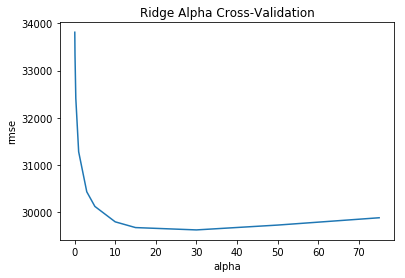

In [288]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Alpha Cross-Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [289]:
ridge = Ridge(alpha=30)
ridge.fit(X_train, np.log(y_train))
y_pred_train = np.exp(ridge.predict(X_train))
print(error(y_train,y_pred_train))

0.10424881632182038


# model_ridge Predictions

In [290]:
submission_ridge = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(ridge.predict(X_test))})
submission_ridge.to_csv('submission_ridge.csv', index = False)

In [293]:
print('Kaggle results with ridge as model and alpha=1: 0.12499')

Kaggle results with ridge as model and alpha=1: 0.12499


# _____ _____ _____

# Testing XGBoost

In [316]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, np.log(y_train))
y_pred_train = np.exp(xgb_model.predict(X_train))
print(error(y_train,y_pred_train))

0.08771595578473802


# XGBoost grid search for best 

In [320]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[12:01:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 

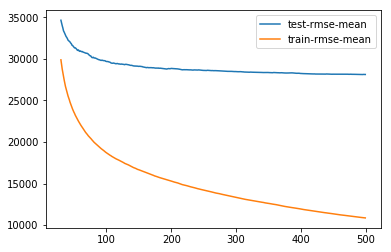

In [322]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [323]:
xgb_model = XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
xgb_model.fit(X_train, np.log(y_train))
y_pred_train = np.exp(xgb_model.predict(X_train))
print(error(y_train,y_pred_train))

0.07949549267031164


# XGBoost Predictions

In [327]:
xgb_preds = np.exp(xgb_model.predict(X_test))

In [328]:
submission_xgb = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(xgb_model.predict(X_test))})
submission_xgb.to_csv('submission_xgb.csv', index = False)

In [330]:
print('Kaggle results with model_xgb as model: 0.13224')

Kaggle results with model_xgb as model: 0.13224


# Grid Search for XGBoost hyper-parameters

In [332]:
from sklearn import cross_validation, metrics  
from sklearn.grid_search import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

from matplotlib.pylab import rcParams

In [373]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

In [424]:
xgb_reg = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid_reg = GridSearchCV(xgb_reg,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid_reg.fit(X_train,y_train)

print(xgb_grid_reg.best_score_)
print(xgb_grid_reg.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=5)]: Done  18 out of  18 | elapsed:   58.9s finished


0.8734590654503553
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [426]:
xgb_reg = XGBRegressor(colsample_bytree= 0.7, 
                    learning_rate= 0.03, 
                    max_depth= 5, 
                    min_child_weight= 4, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb_reg.fit(X_train, np.log(y_train))
y_pred_train = np.exp(xgb_reg.predict(X_train))
print(error(y_train,y_pred_train))

0.050862806873948486


In [427]:
submission_xgb_reg = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(xgb_reg.predict(X_test))})
submission_xgb_reg.to_csv('submission_xgb_reg.csv', index = False)

In [428]:
print('Kaggle results with model xgb_reg as model: 0.12912')

Kaggle results with model xgb_reg as model: 0.12912


# Grid Search with more hyperparameters

In [421]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.01,0.03,0.05,0.07], #so called `eta` value
              'max_depth': [4,5,6,7,8],
              'min_child_weight': [1,3,4],
              'silent': [1],
              'subsample': [0.7,0.9,1],
              'colsample_bytree': [0.7,0.9,1],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 540 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  8.9min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 21.7min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 42.5min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 62.0min finished


0.8833235480327196
{'colsample_bytree': 1, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [429]:
xgb1 = XGBRegressor(colsample_bytree=1, 
                    learning_rate= 0.03, 
                    max_depth= 4, 
                    min_child_weight= 3, 
                    n_estimators= 500, 
                    nthread= 4, 
                    objective= 'reg:linear', 
                    silent= 1, 
                    subsample= 0.7)

xgb1.fit(X_train, np.log(y_train))
y_pred_train = np.exp(xgb1.predict(X_train))
print(error(y_train,y_pred_train))

0.06164044663652043


In [430]:
submission_xgb1 = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(xgb1.predict(X_test))})
submission_xgb1.to_csv('submission_xgb1.csv', index = False)

In [431]:
print('Kaggle results with model_xgb1 as model: 0.12911')

Kaggle results with model_xgb1 as model: 0.12911


# xgb1 train_test_split

In [432]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.2)
print (XX_train.shape, yy_train.shape)
print (XX_test.shape, yy_test.shape)

(1168, 383) (1168,)
(292, 383) (292,)


In [433]:
xgb1.fit(XX_train, np.log(yy_train))

yy_pred_train = np.exp(lasso.predict(XX_train))
error(yy_train, yy_pred_train)

0.1192718302777584

In [434]:
submission_xgb1 = pd.DataFrame({"Id": test["Id"], "SalePrice": np.exp(xgb1.predict(X_test))})
submission_xgb1.to_csv('submission_xgb1.csv', index = False)

In [435]:
print('Kaggle results with train_test_split model_xgb1 as model: 0.12950')

Kaggle results with train_test_split model_xgb1 as model: 0.12950
